In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import mean_squared_error
import src.time_series_helpers as th

In [7]:
ls data/

LSTM_10_output_forecast.csv  processed_train.csv
LSTM_500_by_item.csv         sample_submission.csv
LSTM_500_forecast.csv        sample_valid.csv
VAR_by_item.csv              store_item.csv
VAR_forecast.csv             test.csv
lstm_10_by_item.csv          train.csv
lstm_data.csv


In [8]:
df = pd.read_csv('data/train.csv')
df.shape

(913000, 4)

In [9]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
#set datatime to index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [6]:
#split into train and valid sets
train_original = df.loc['2013-01-01':'2017-09-30']
valid_original  = df.loc['2017-10-01':'2017-12-31']

In [7]:
# y_train = train.pop('sales')
# X_train = train.copy()
# y_test =  valid.pop('sales')
# X_test = valid.copy()

In [8]:
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [9]:
# df.sales.sum()==y_train.sum()+y_test.sum()

### Modeling by daily

In [10]:
df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [11]:
daily_avg_sales = df.resample('D').mean()
daily_avg_sales.head()

,store,item,sales
date,,,
2013-01-01,5.5,25.5,27.392
2013-01-02,5.5,25.5,27.356
2013-01-03,5.5,25.5,28.976
2013-01-04,5.5,25.5,31.354
2013-01-05,5.5,25.5,32.474


#### Splitting the data into training and validation part

In [12]:
Train = daily_avg_sales.loc['2013-01-01':'2017-09-30']
valid = daily_avg_sales.loc['2017-10-01':'2017-12-31']

In [13]:
decomposition = sm.tsa.seasonal_decompose(Train.sales, model='additive')

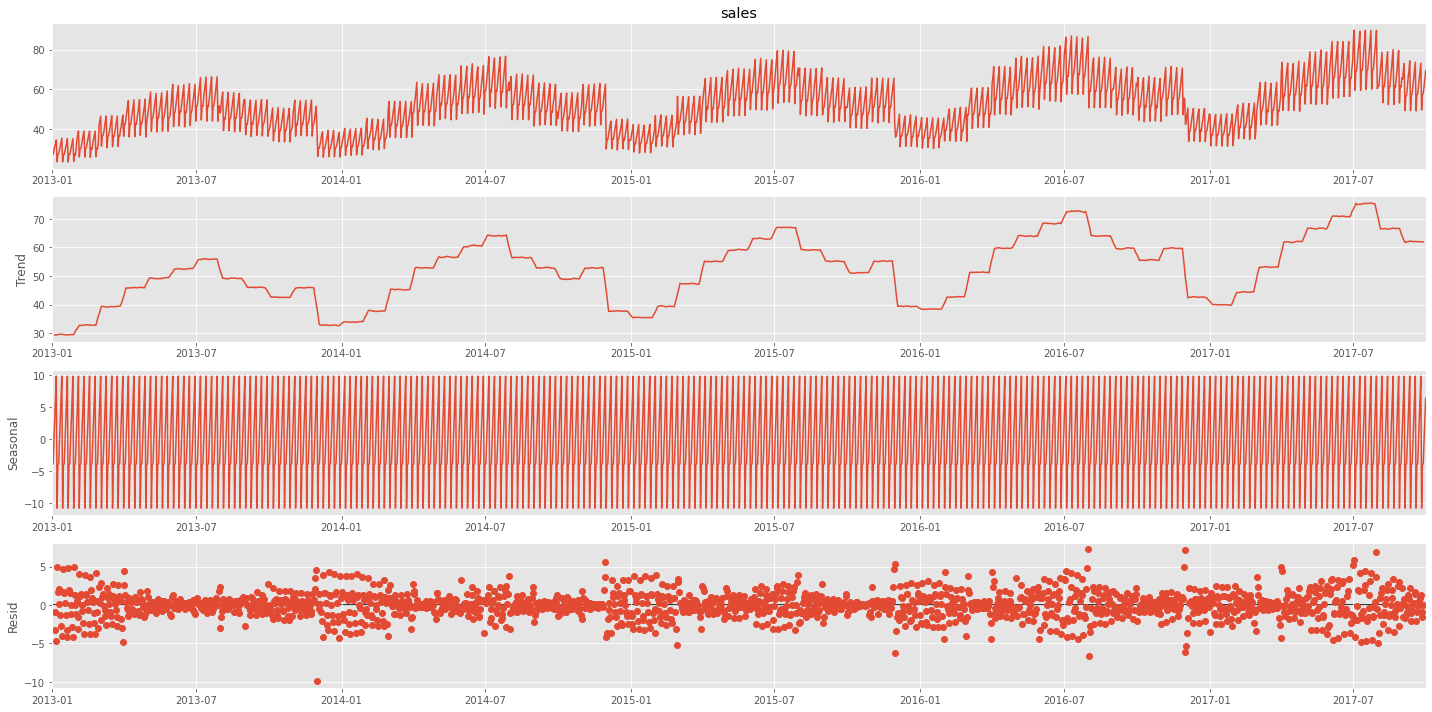

In [14]:
plt.rcParams['figure.figsize'] = 20, 10
fig = decomposition.plot()
plt.show()

### Holt's Linear Trend Model

In [15]:
from statsmodels.tsa.api import Holt

In [16]:
y_hat_avg = valid.copy()
holt = Holt(np.asarray(Train['sales'])).fit(smoothing_level = 0.3, 
                                            smoothing_slope = 0.02)
y_hat_avg['holt_linear'] = holt.forecast(len(valid))

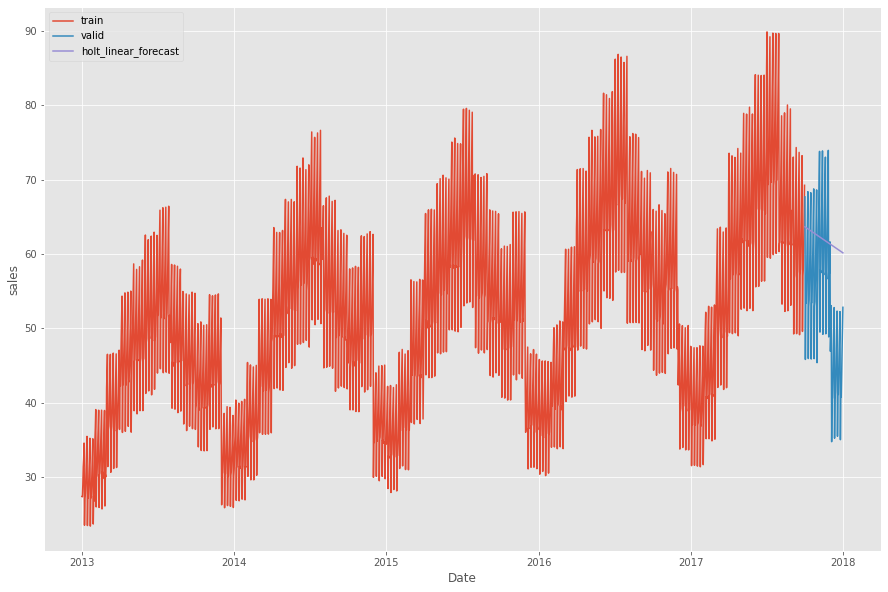

In [17]:
plt.figure(figsize =(15,10))
plt.plot(Train['sales'], label = 'train')
plt.plot(valid['sales'], label = 'valid')
plt.plot(y_hat_avg['holt_linear'], label = 'holt_linear_forecast')
plt.xlabel("Date")
plt.ylabel("sales")
plt.legend(loc = 'best')
plt.show
plt.savefig('images/holt_linear_forecast.png')

In [67]:
#plot forecast VS actuals

figtitle = 'store1  item1 sales LSTM forecast(one year)'
th.plot_results(df_forecast, valid, figtitle)

NameError: name 'df_forecast' is not defined

### ARIMA Model

#### Stationarity Check

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
daily_avg_sales

,store,item,sales
date,,,
2013-01-01,5.5,25.5,27.392
2013-01-02,5.5,25.5,27.356
2013-01-03,5.5,25.5,28.976
2013-01-04,5.5,25.5,31.354
2013-01-05,5.5,25.5,32.474
...,...,...,...
2017-12-27,5.5,25.5,40.756
2017-12-28,5.5,25.5,43.770
2017-12-29,5.5,25.5,47.070


In [20]:
test = sm.tsa.stattools.adfuller(daily_avg_sales.sales)
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 0.03


In [57]:
## It is Non-stationary

#### Differencing Check

In [22]:
def plot_series_and_difference(axs, series, title):
    diff = series.sales.diff()
    axs[0].plot(series.index, series.sales)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

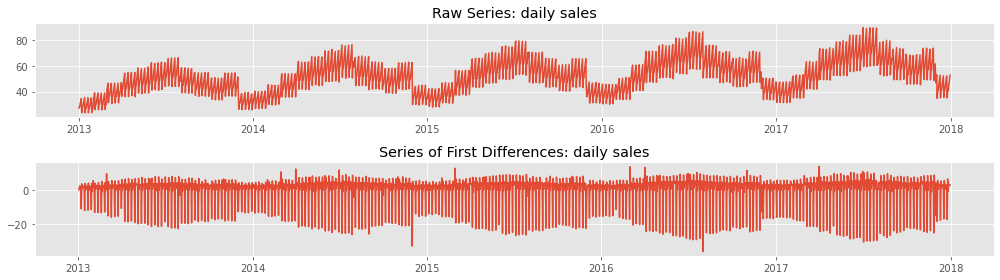

In [23]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, daily_avg_sales, 'daily sales')
fig.tight_layout()

In [24]:
yt = daily_avg_sales.sales.diff()[1:]  # the 0th value is NAN
test = sm.tsa.stattools.adfuller(yt)
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 0.00


In [25]:
# Good enough.

#### ACF and PACF plot

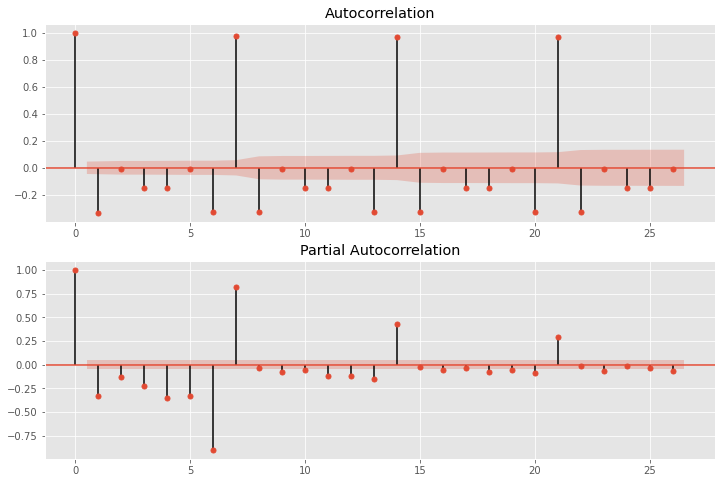

In [26]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(yt, lags=52/2, ax=ax1)  
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(yt, lags=52/2, ax=ax2) 

In [27]:
afc = sm.tsa.stattools.acf(yt)
len(afc)

/Users/nicochen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


41

In [28]:
pacf =sm.tsa.stattools.pacf(yt)
len(pacf)

41

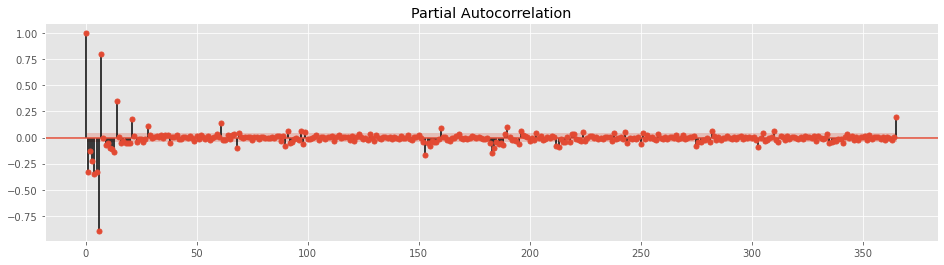

In [29]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(yt, ax=ax,lags=365, method='ywmle')

plt.show()

### SARIMAX Model

In [30]:
daily_avg_sales = df['sales'].resample('D').mean()

In [31]:
model = sm.tsa.statespace.SARIMAX(daily_avg_sales,
                                order=(4, 1, 3),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = model.fit()

/Users/nicochen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [32]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5030      0.029     17.200      0.000       0.446       0.560
ar.L2         -0.5285      0.036    -14.810      0.000      -0.598      -0.459
ar.L3         -0.1754      0.037     -4.704      0.000      -0.249      -0.102
ar.L4         -0.4544      0.034    -13.542      0.000      -0.520      -0.389
ma.L1         -1.7867      0.023    -78.186      0.000      -1.832      -1.742
ma.L2          1.7504      0.029     61.257      0.000       1.694       1.806
ma.L3         -0.5956      0.026    -22.542      0.000      -0.647      -0.544
ma.S.L12      -1.0003      0.386     -2.593      0.010      -1.756      -0.244
sigma2        19.0254      7.570      2.513      0.012       4.188      33.863


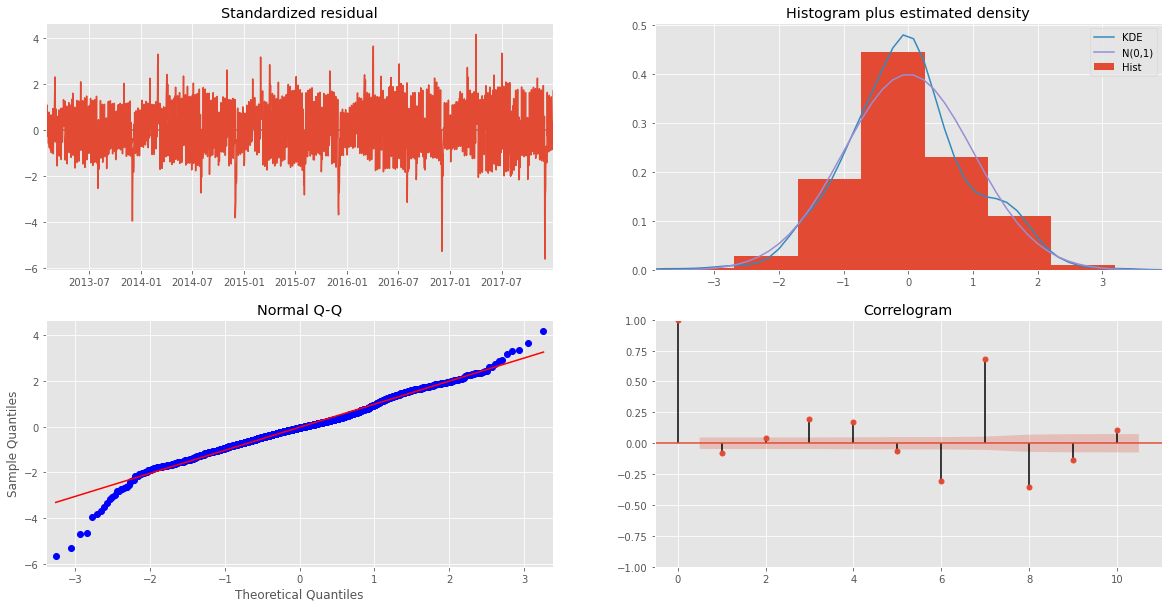

In [33]:
results.plot_diagnostics(figsize=(20, 10))
plt.show()

In [34]:
#MODEL Evaluation and Analysis

In [35]:
pred = results.get_prediction(start=pd.to_datetime('2017-10-01'), dynamic=False)

In [59]:
#Confidence interval
pred_ci = pred.conf_int()

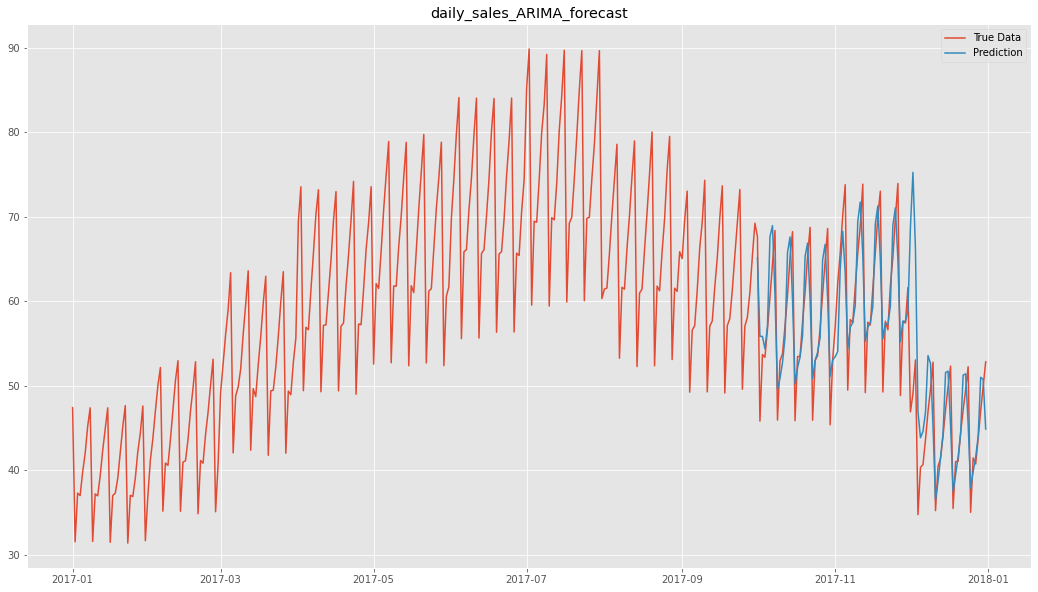

Plot saved.


In [69]:
#Plotting real and forecasted values.

figtitle = 'daily_sales_ARIMA_forecast'
th.plot_results(pred.predicted_mean, daily_avg_sales['2017':], figtitle)



In [36]:
#Calculating the Forecast Accuracy

#Calculating the mean squared error (average error of forecasts) and the lower Mean Square Error always reflects the better results 
y_forecasted = pred.predicted_mean
y_truth = daily_avg_sales['2017-10-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

MSE 34.07
RMSE: 5.84


In [80]:
RMSE  = th.rmse_calculate(y_forecasted,y_truth)
# print(round(RMSE, 2))
print(RMSE)

5.84


In [37]:
df['sales'].mean()

52.250286966046005

#### Modeling by item and store

In [38]:
df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [39]:
store_item = pd.pivot_table(df, values='sales', index=['date'],
                    columns=['store','item'], aggfunc=np.sum)
store_item.tail()

store       1                                       ...  10                  \
item        1   2   3   4   5   6   7   8   9   10  ...  41  42  43  44  45   
date                                                ...                       
2017-12-27  14  55  26  16   6  32  45  58  37  55  ...  14  35  41  22  64   
2017-12-28  19  50  21  20  15  51  36  49  34  63  ...  18  37  47  30  79   
2017-12-29  15  50  38  25  17  55  57  54  46  56  ...  26  37  52  30  72   
2017-12-30  27  56  27  19  22  55  60  75  37  78  ...  22  44  58  30  76   
2017-12-31  23  67  29  15  17  53  55  62  50  74  ...  22  33  56  40  89   

store                           
item        46  47  48  49  50  
date                            
2017-12-27  50  16  52  24  63  
2017-12-28  48  21  36  29  59  
2017-12-29  69  18  59  26  74  
2017-12-30  72  10  54  40  62  
2017-12-31  70  22  60  42  82  

[5 rows x 500 columns]

In [40]:
store_item.shape

(1826, 500)

In [41]:
columns = store_item.columns.tolist()

In [42]:
df_1 = store_item.loc[:,(1, 20)]
df_1

date
2013-01-01    22
2013-01-02    16
2013-01-03    24
2013-01-04    24
2013-01-05    36
              ..
2017-12-27    29
2017-12-28    29
2017-12-29    51
2017-12-30    38
2017-12-31    47
Name: (1, 20), Length: 1826, dtype: int64

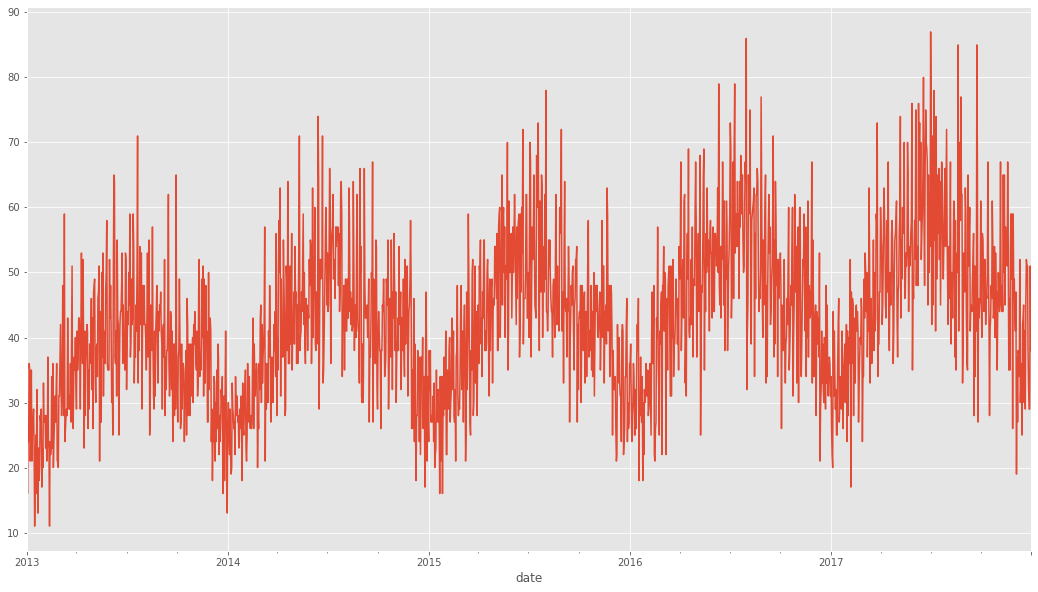

In [43]:
df_1.plot(figsize=(18,10))

In [45]:
train_1 = df_1.loc['2013-01-01':'2017-09-30']
valid_1 = df_1.loc['2017-10-01':'2017-12-31']

In [47]:
decompose_1 = sm.tsa.seasonal_decompose(train_1)
result_1   = sm.tsa.stattools.adfuller(valid_1)  

<Figure size 2016x720 with 0 Axes>

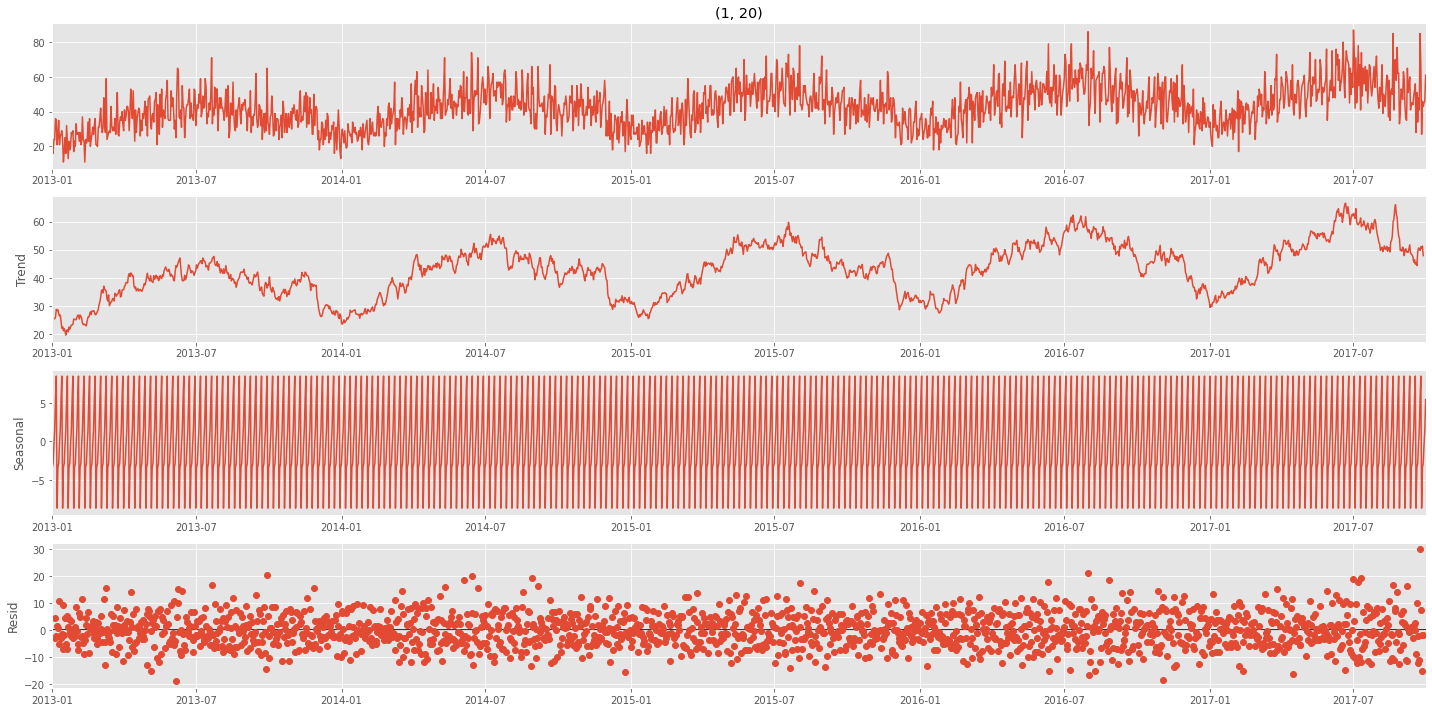

In [48]:
plt.figure(figsize =(28,10))
decompose_1.plot()
plt.show()

In [49]:
y_hat_avg = valid.copy()
model_1 = SARIMAX(train_1, order = (2,1,3), seasonal_order =(0,1,1,12))
results_1 = model_1.fit()

/Users/nicochen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/nicochen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/nicochen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [50]:
pred_1 =results_1.get_prediction(start='2017-10-01', 
                                     end = '2017-12-31',)

In [51]:
pred_1

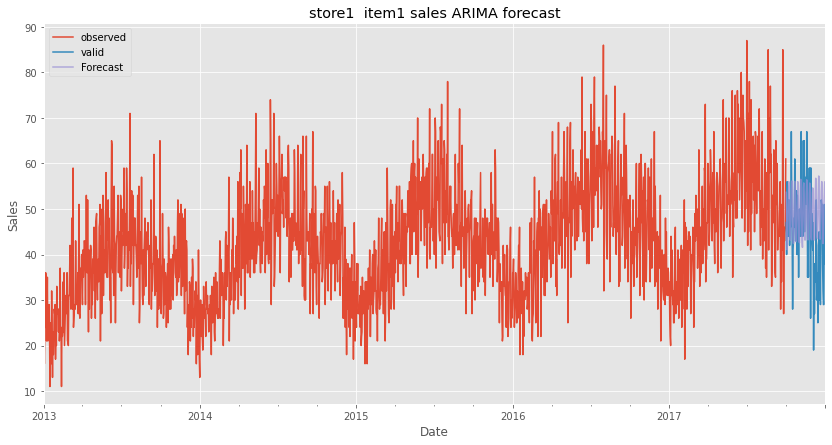

<Figure size 1440x720 with 0 Axes>

In [52]:
#Plotting real and forecasted values.

ax = train_1.plot(label='observed')
ax = valid_1.plot(label='valid')
pred_1.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title("store1  item1 sales ARIMA forecast")
plt.legend()
plt.show()
plt.savefig('images/daily_sales_ARIMA_forecast.png')

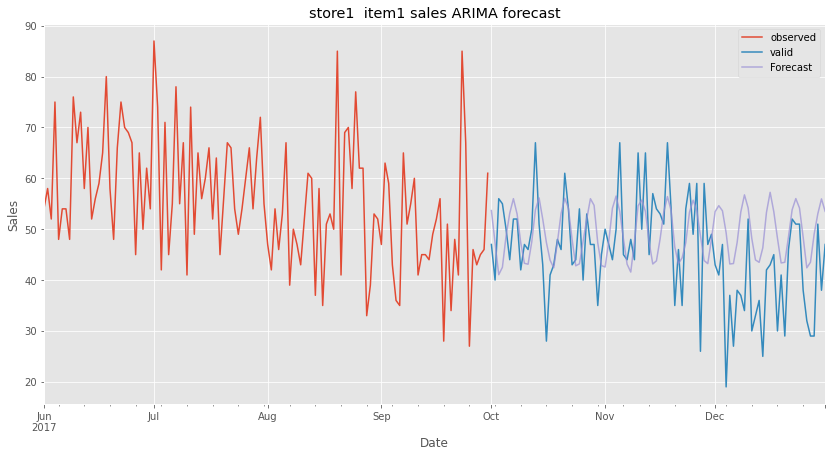

<Figure size 1440x720 with 0 Axes>

In [61]:
#Plotting real and forecasted values.

ax = train_1['2017-6-1':].plot(label='observed')
ax = valid_1.plot(label='valid')
pred_1.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title("store1  item1 sales ARIMA forecast")
plt.legend()
plt.show()
plt.savefig('images/daily_sales_ARIMA_forecast.png')

In [83]:
y_forecasted_1 = pred_1.predicted_mean
y_forecasted_1.head()

2017-10-01    53.667166
2017-10-02    47.320225
2017-10-03    41.055084
2017-10-04    42.506222
2017-10-05    48.675301
Freq: D, dtype: float64

In [81]:
#Calculating the Forecast Accuracy

#Calculating the mean squared error (average error of forecasts) and the lower Mean Square Error always reflects the better results 
y_forecasted_1 = pred_1.predicted_mean

RMSE_s1_i1  = th.rmse_calculate(df_forecast.iloc[:,0],valid.iloc[:,0])
print(RMSE_s1_i1)
m

MSE 2017-10-01 00:00:00   NaN
2017-10-02 00:00:00   NaN
2017-10-03 00:00:00   NaN
2017-10-04 00:00:00   NaN
2017-10-05 00:00:00   NaN
                       ..
2017-12-30 00:00:00   NaN
2017-12-31 00:00:00   NaN
item                  NaN
sales                 NaN
store                 NaN
Length: 95, dtype: float64
RMSE: 2017-10-01 00:00:00   NaN
2017-10-02 00:00:00   NaN
2017-10-03 00:00:00   NaN
2017-10-04 00:00:00   NaN
2017-10-05 00:00:00   NaN
                       ..
2017-12-30 00:00:00   NaN
2017-12-31 00:00:00   NaN
item                  NaN
sales                 NaN
store                 NaN
Length: 95, dtype: float64


In [59]:
valid.mean()

store     5.500000
item     25.500000
sales    54.677543
dtype: float64

### Multivariate Forecast Model
#### Vector Autoregression (VAR)